In [1]:
import geopandas as gpd
import folium
import os
from PIL import Image
from sentinelsat.sentinel import SentinelAPI, read_geojson, geojson_to_wkt
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
#from geojson import Point
from geojson import Polygon
import geojson
import tempfile
import datetime as dt
from shapely.geometry import MultiPolygon, Polygon
import rasterio as rio
from rasterio import plot
import rasterio.mask
import fiona
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from skimage import exposure

Normalized Burn Ratio (NBR):

The Normalized burn ratio (NBR) is used to identify burned areas. The formula is similar to a normalized difference vegetation index (NDVI), except that it uses near-infrared (NIR) and shortwave-infrared (SWIR) portions of the electromagnetic spectrum (Lopez, 1991; Key and Benson, 1995).

The normalized burn ratio (NBR) index uses the shortwave-infrared (SWIR) and near-infrared (NIR) portions of the electromagnetic spectrum.
The NIR and SWIR parts of the electromagnetic spectrum are a powerful combination of bands to use for this index given vegetation reflects strongly in the NIR region of the electromagnetic spectrum and weakly in the SWIR. Alternatively, it has been shown that a fire scar which contains scarred woody vegetation and earth will reflect more strongly in the SWIR part of the electromagnetic spectrum and beyond.

Your task:

Read the following article: https://www.cataniatoday.it/cronaca/etna-eruzione-boati-lava-lapilli7-marzo-2021.html

1. Research bands required for NBR.
2. Search and download the Sentinel-2 product covering the Etna volcano on 03/03/2021
3. Using QGis draw and export (GeoJSON) an ROI polygon around the Etna region.
4. Load and mask the Sentinel Product to the Etna ROI.
5. Display and save the masked image as RGB.
6. Calculate NBR using the above formula and save the NBR image.
7. Display the NBR image using Rasterio using: plot.show(out_image, cmap='RdYlGn')

S2B_MSIL1C_20210303T095029_N0209_R079_T33SVB_20210303T105137

NBR

In this step the corrected images are used. In order to generate the burn severity map, the bands B8A and B12 are used. Thus, in the following code (after the function definitions) the bands of both pre- and post-fire images are loaded and the NBR is calculated. As it is already mentioned NBR is calculated using the NIR and SWIR bands of Sentinel-2 in this practice, using the formula shown below:

NBR = (NIR - SWIR) / (NIR + SWIR)

NBR = (B8A - B12) / (B8A + B12)

In [2]:
# import bands as separate 1 band raster
imagePath = '..\data/2015\S2A_MSIL1C_20151112T094232_N0204_R036_T33SVV_20151112T094226.SAFE\GRANULE\L1C_T33SVV_A002035_20151112T094226\IMG_DATA/'

# Load polygon vector of AI (e.g.Gozo) to clip satellite image
boundsdata = r'../data/scale3.geojson'
region = gpd.read_file(boundsdata)
print(region)
nReserve_proj = region.to_crs({'init': 'epsg:32633'})


   id                                           geometry
0   1  MULTIPOLYGON (((14.43519 35.95796, 14.40944 35...


C:\Users\MCAST\anaconda3\envs\remsen\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


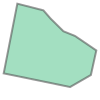

In [3]:
# Show footprint
footprint = None
for i in region['geometry']:
    footprint = i
footprint

In [4]:
#View on a folium map

m = folium.Map(location=[37.75,15.0000], zoom_start=10)

folium.GeoJson(footprint).add_to(m)
m


In [5]:
# Open b4 and b8
b8A = rasterio.open(imagePath+'T33SVV_20151112T094232_B8A.jp2')
b12 = rasterio.open(imagePath+'T33SVV_20151112T094232_B12.jp2')
tci = rasterio.open(imagePath+'T33SVV_20151112T094232_TCI.jp2')

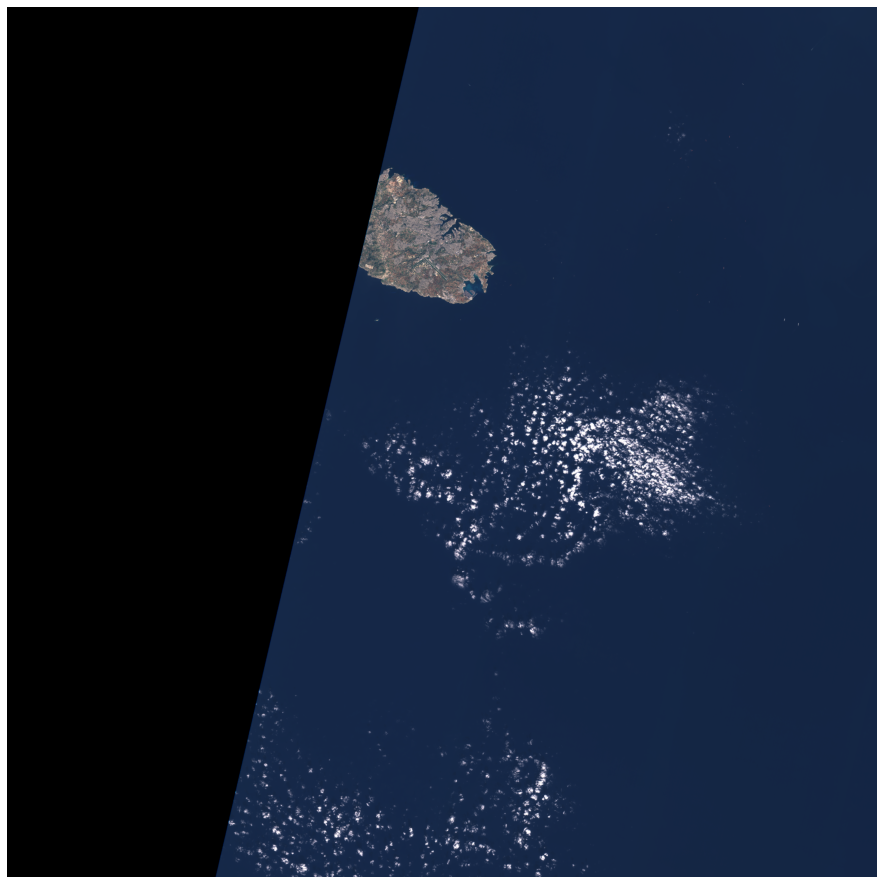

In [6]:
#Display TCI
fig = plt.figure(figsize=(20,16))
ax=fig.add_subplot(1,1,1)
plt.axis('off')
plot.show(tci)

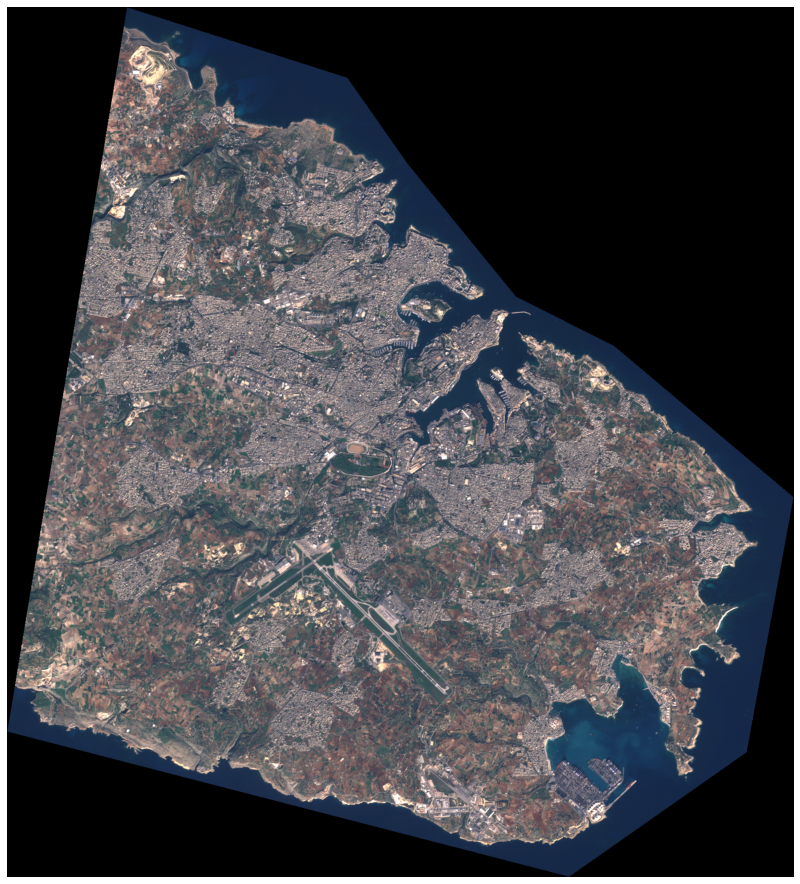

In [7]:
#Display cropped TCI

tci_cropped, cropped_transform = rio.mask.mask(tci, nReserve_proj.geometry,crop=True)

fig = plt.figure(figsize=(20,16))
ax=fig.add_subplot(1,1,1)
plt.axis('off')
plot.show(tci_cropped)

In [8]:
# read Red(b4) and NIR(b8) as arrays
nir = b8A.read()
swir = b12.read()

# Do not display error when divided by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculate NBR
nbr = (nir.astype(float)-swir.astype(float))/(nir+swir)

#Print NBR min and max
print(np.nanmin(nbr))
print(np.nanmax(nbr))

# get the dtype of our NBR array:
nbr_dtype = nbr.dtype
print(nbr_dtype)

# Write the NBR image
meta = b8A.meta
meta.update(driver='GTiff')
meta.update(dtype=rasterio.float64)

with rasterio.open('../Output/NBR.tif', 'w', **meta) as dst:
    dst.write(nbr)
    #dst.write(ndvi.astype(rasterio.float32))

-0.9622641509433962
1.0
float64


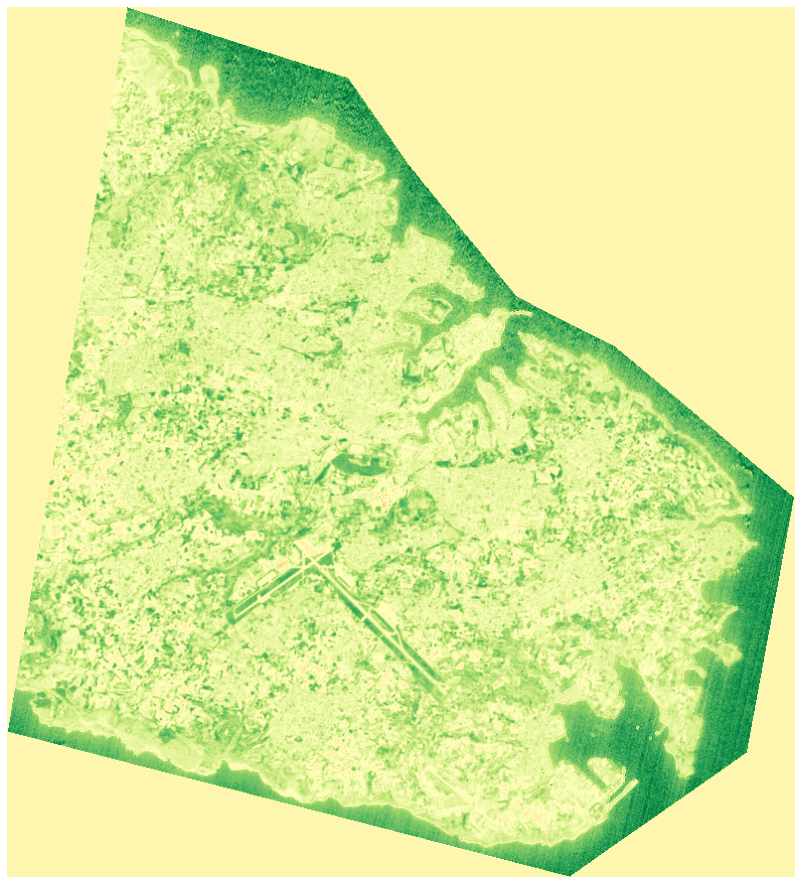

Min NBR: -0.8767123287671232
Max NBR: 0.9891304347826086


In [9]:
# Crop NBR to ROI

with rio.open("../Output/NBR.tif") as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open('../Output/NBR_cropped.tif', 'w', **meta) as dst:
    dst.write(out_image)

fig = plt.figure(figsize=(20,16))
ax=fig.add_subplot(1,1,1)
plt.axis('off')
plot.show(out_image, cmap='RdYlGn')

#Print NDVI min and max
print('Min NBR:', np.nanmin(out_image))
print('Max NBR:', np.nanmax(out_image))





